In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import torch
import pandas as pd
from torchvision.ops import nms

!pip install ultralytics -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


In [ ]:
# Function to perform YOLO object detection
def yolo_object_detection(image_path, weights_path, conf_threshold=0.5):
    model = YOLO(weights_path)
    img0 = cv2.imread(image_path)
    img = img0.copy()

    # Inference
    results = model.predict(img)

    # NMS
    # results = nms(results, conf_threshold=conf_threshold)

    return img, results

In [ ]:
# Function to split image and save
def split_image(image):
    height, width, _ = image.shape
    mid_point = width // 2
    left_image = image[:, :mid_point, :]
    right_image = image[:, mid_point:, :]

    # cv2.imwrite(output_path_left, left_image)
    # cv2.imwrite(output_path_right, right_image)

    return left_image, right_image

In [ ]:
# Function to perform YOLOv8 object detection for seatbelt
def yolo_v8_object_detection(image, weights_path, conf_threshold=0.5):
    model = YOLO(weights_path)
    img = image

    # Inference
    results = model.predict(img)

    # NMS
    # results = nms(results, conf_threshold=conf_threshold)

    return results

In [ ]:
# Function to visualize the results with bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_results(image, results, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    if results is not None and len(results[0].boxes) > 0:
        result_list = results[0].boxes.xyxy.cpu().numpy().tolist()
        for box in result_list:
            if len(box) == 4:
                # Handle xyxy format
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none")
            elif len(box) == 5:
                # Handle xywh format
                x, y, w, h, conf = box
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
            else:
                # Handle other result structures
                x, y, w, h = box[:4]
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")

            ax.add_patch(rect)

    plt.title(title)
    plt.axis("off")
    plt.show()


In [ ]:
from google.colab.patches import cv2_imshow
# Main pipeline
def car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path):
    # Step 1: Perform YOLO Object Detection for Windshield
    car_image, yolo_results = yolo_object_detection(input_image_path, yolo_weights_path)

    # Assuming the first result is the windshield
    windshield_box = yolo_results[0].boxes.xyxy.cpu().numpy()

    # Crop the windshield
    x1, y1, x2, y2 = map(int, windshield_box[0, :])
    windshield_image = car_image[y1:y2, x1:x2]

    # Visualize YOLO results for the windshield
    print("Results for windshield:")
    print(yolo_results)
    print("\n")
    visualize_results(car_image, yolo_results, "Object Detection - Windshield")
    print("\n")

    # Step 2: Split Windshield into Two Pictures
    left_image, right_image = split_image(windshield_image.copy())

    # Step 3: Perform YOLOv8 Object Detection for Seatbelt on Left and Right Images
    left_results = yolo_v8_object_detection(left_image.copy(), yolo_v8_weights_path)
    right_results = yolo_v8_object_detection(right_image.copy(), yolo_v8_weights_path)


    # Print or process the results as needed
    print("Results for Driver Side:")
    # print(left_results)
    print("\n")

    # Visualize YOLOv8 results for left and right windshield segments
    visualize_results(left_image, left_results, "SeatBelt Detection - Driver Side")
    print("\n")

    print("Results for Passenger Side:")
    # print(right_results)
    print("\n")


    # Visualize YOLOv8 results for left and right windshield segments
    visualize_results(right_image, right_results, "SeatBelt Detection - Passenger Side")

In [ ]:
import os
# Paths to YOLO and YOLOv8 weights
yolo_weights_path = "/content/drive/MyDrive/SeatBelt_project/Weights/windsheildWbest.pt"
yolo_v8_weights_path = "/content/drive/MyDrive/SeatBelt_project/Weights/Seat_Belt_weights_dwconv.pt"


# # Replace 'your_image_path.jpg' with the path to your car image
# input_image_path = "/content/drive/MyDrive/SeatBelt_project/Challanges/41_14968680.jpg"

# # Run the pipeline
# car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)

# Replace 'your_folder_path' with the path to your folder containing car images
input_folder_path = "/content/drive/MyDrive/SeatBelt_project/Challanges"

# Function to process a folder of images
def process_folder(folder_path, yolo_weights_path, yolo_v8_weights_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(('.jpg', '.jpeg', '.png')):
            input_image_path = os.path.join(folder_path, file_name)
            print(f"Processing {input_image_path}")
            car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)

# Run the pipeline for each image in the folder
process_folder(input_folder_path, yolo_weights_path, yolo_v8_weights_path)

Output hidden; open in https://colab.research.google.com to view.


0: 480x800 1 car-windshield, 16.2ms
Speed: 2.9ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)
Results for windshield:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car-windshield'}
obb: None
orig_img: array([[[63, 63, 63],
        [69, 69, 69],
        [69, 69, 69],
        ...,
        [78, 78, 78],
        [78, 78, 78],
        [78, 78, 78]],

       [[63, 63, 63],
        [69, 69, 69],
        [69, 69, 69],
        ...,
        [78, 78, 78],
        [78, 78, 78],
        [78, 78, 78]],

       [[63, 63, 63],
        [69, 69, 69],
        [69, 69, 69],
        ...,
        [78, 78, 78],
        [78, 78, 78],
        [78, 78, 78]],

       ...,

       [[56, 46, 39],
        [56, 46, 39],
        [56, 46, 39],
        ...,
        [66, 69, 73],
        [66, 69, 73],
        [66, 69, 73]],

       [[57, 47, 40],
        [57, 47, 40],
        [57,

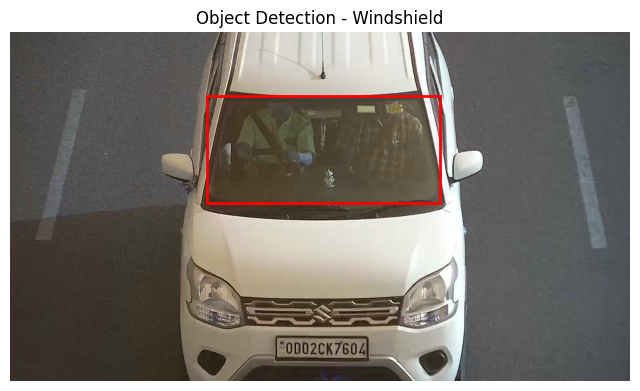




0: 608x640 1 Seat_Belt, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 Seat_Belt, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
Results for Driver Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[140, 127, 113],
        [136, 123, 109],
        [143, 130, 116],
        ...,
        [203, 194, 184],
        [203, 194, 184],
        [203, 194, 184]],

       [[139, 126, 112],
        [136, 123, 109],
        [150, 137, 123],
        ...,
        [151, 142, 132],
        [150, 141, 131],
        [149, 140, 130]],

       [[138, 125, 111],
        [138, 125, 111],
        [157, 144, 130],
        ...,
        [ 92,  83,  73],
        [ 91,  82,  72],
        [ 90,  81,  71]],

       ...,

       [[ 64,  49,  30],
      

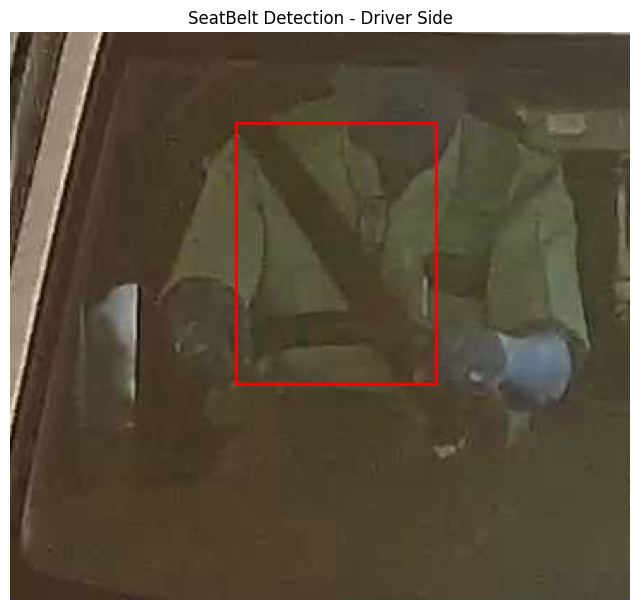



Results for Passenger Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[203, 194, 184],
        [202, 193, 183],
        [202, 193, 183],
        ...,
        [ 67,  59,  60],
        [ 80,  74,  75],
        [121, 116, 117]],

       [[148, 139, 129],
        [147, 138, 128],
        [145, 136, 126],
        ...,
        [ 63,  55,  56],
        [ 64,  58,  59],
        [ 94,  89,  90]],

       [[ 87,  78,  68],
        [ 85,  76,  66],
        [ 83,  74,  64],
        ...,
        [ 61,  53,  54],
        [ 54,  48,  49],
        [ 78,  73,  74]],

       ...,

       [[ 83,  76,  61],
        [ 83,  76,  61],
        [ 84,  77,  62],
        ...,
        [ 95,  92,  78],
        [ 96,  93,  79],
        [ 97,  94,  80]],

       [[ 83,  76,  61],
        [ 83,  76,  61],
        [ 84,  77,  62],
        ...,
        [ 95,  92,  78],
    

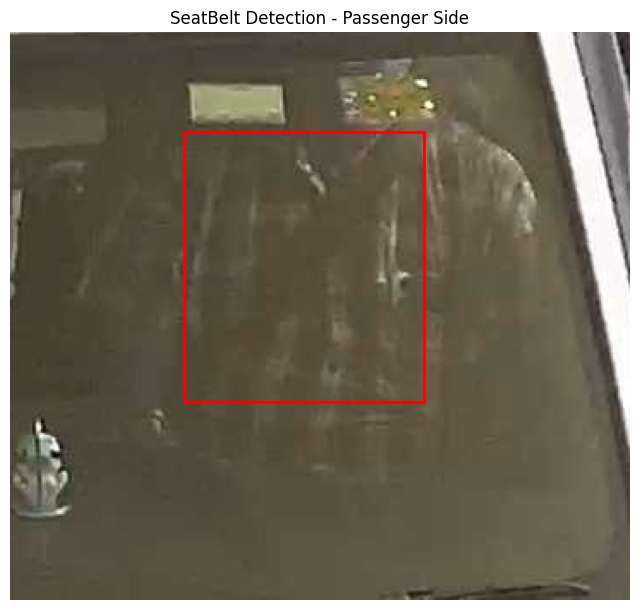

In [ ]:
# Paths to YOLO and YOLOv8 weights
yolo_weights_path = "/content/windsheildWbest.pt"
yolo_v8_weights_path = "/content/Seat_Belt_weights_dwconv.pt"


# Replace 'your_image_path.jpg' with the path to your car image
input_image_path = "/content/27_3954696.jpg"

# Run the pipeline
car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)


0: 480x800 1 car-windshield, 16.1ms
Speed: 2.9ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 800)
Results for windshield:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car-windshield'}
obb: None
orig_img: array([[[70, 71, 67],
        [70, 71, 67],
        [70, 71, 67],
        ...,
        [82, 87, 86],
        [82, 87, 86],
        [82, 87, 86]],

       [[70, 71, 67],
        [70, 71, 67],
        [70, 71, 67],
        ...,
        [82, 87, 86],
        [82, 87, 86],
        [82, 87, 86]],

       [[70, 71, 67],
        [70, 71, 67],
        [70, 71, 67],
        ...,
        [82, 87, 86],
        [82, 87, 86],
        [82, 87, 86]],

       ...,

       [[66, 56, 49],
        [66, 56, 49],
        [66, 56, 49],
        ...,
        [63, 66, 70],
        [66, 69, 73],
        [68, 71, 75]],

       [[67, 57, 50],
        [67, 57, 50],
        [67,

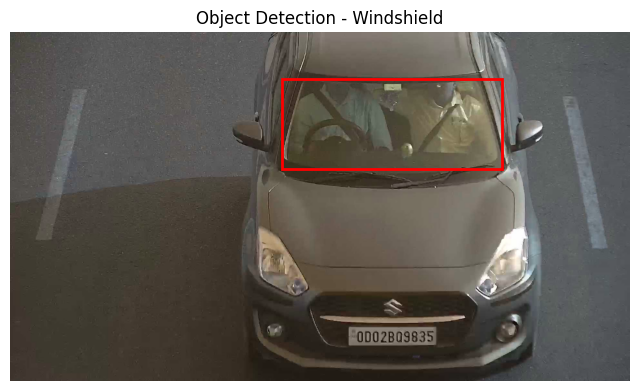




0: 544x640 1 Seat_Belt, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 2 Seat_Belts, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
Results for Driver Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[83, 77, 70],
        [84, 78, 71],
        [85, 79, 72],
        ...,
        [66, 61, 52],
        [66, 61, 52],
        [66, 61, 52]],

       [[85, 79, 72],
        [85, 79, 72],
        [85, 79, 72],
        ...,
        [66, 60, 53],
        [65, 59, 52],
        [66, 60, 53]],

       [[85, 79, 72],
        [85, 79, 72],
        [85, 79, 72],
        ...,
        [64, 58, 53],
        [63, 57, 52],
        [64, 58, 53]],

       ...,

       [[55, 48, 33],
        [55, 48, 33],
        [55, 48, 33],
        ...,
     

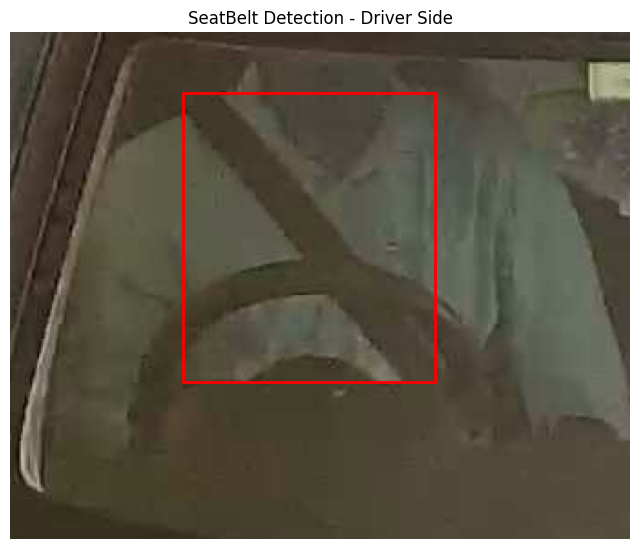



Results for Passenger Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[ 66,  61,  52],
        [ 66,  61,  52],
        [ 70,  66,  55],
        ...,
        [121, 125, 126],
        [126, 129, 133],
        [124, 128, 129]],

       [[ 67,  61,  54],
        [ 68,  62,  55],
        [ 64,  59,  50],
        ...,
        [122, 127, 126],
        [126, 130, 131],
        [128, 133, 132]],

       [[ 65,  59,  54],
        [ 66,  60,  53],
        [ 64,  59,  50],
        ...,
        [121, 126, 125],
        [125, 130, 129],
        [127, 132, 131]],

       ...,

       [[ 83,  76,  61],
        [ 83,  76,  61],
        [ 82,  75,  60],
        ...,
        [118, 109,  99],
        [108,  99,  89],
        [ 75,  66,  56]],

       [[ 83,  76,  61],
        [ 83,  76,  61],
        [ 82,  75,  60],
        ...,
        [111, 102,  92],
    

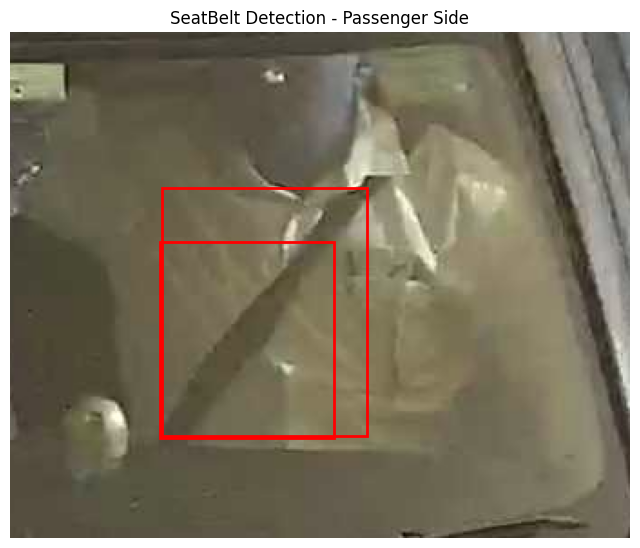

In [ ]:
# Paths to YOLO and YOLOv8 weights
yolo_weights_path = "/content/windsheildWbest.pt"
yolo_v8_weights_path = "/content/Seat_Belt_weights_dwconv.pt"


# Replace 'your_image_path.jpg' with the path to your car image
input_image_path = "/content/27_3954780.jpg"

# Run the pipeline
car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)


0: 480x800 1 car-windshield, 17.5ms
Speed: 2.7ms preprocess, 17.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 800)
Results for windshield:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car-windshield'}
obb: None
orig_img: array([[[ 85, 100, 119],
        [ 81,  96, 115],
        [ 81,  96, 115],
        ...,
        [ 72,  64,  74],
        [ 72,  64,  74],
        [ 72,  64,  74]],

       [[ 78,  93, 112],
        [ 70,  85, 104],
        [ 66,  81, 100],
        ...,
        [ 72,  64,  74],
        [ 72,  64,  74],
        [ 72,  64,  74]],

       [[ 61,  76,  95],
        [ 53,  68,  87],
        [ 51,  66,  85],
        ...,
        [ 72,  64,  74],
        [ 72,  64,  74],
        [ 72,  64,  74]],

       ...,

       [[ 60,  55,  56],
        [ 60,  55,  56],
        [ 60,  55,  56],
        ...,
        [ 60,  57,  66],
        [ 61,  58,  67],
        [ 6

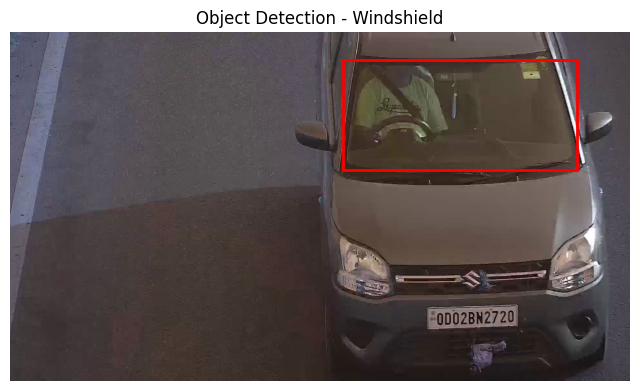




0: 608x640 1 Seat_Belt, 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 (no detections), 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)
Results for Driver Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[76, 71, 72],
        [76, 71, 72],
        [74, 69, 70],
        ...,
        [58, 48, 41],
        [58, 48, 41],
        [58, 48, 41]],

       [[77, 72, 73],
        [77, 72, 73],
        [73, 68, 69],
        ...,
        [55, 45, 38],
        [55, 45, 38],
        [58, 48, 41]],

       [[78, 73, 74],
        [78, 73, 74],
        [72, 67, 68],
        ...,
        [58, 48, 41],
        [58, 48, 41],
        [59, 49, 42]],

       ...,

       [[53, 38, 29],
        [54, 39, 30],
        [54, 39, 30],
        ...,


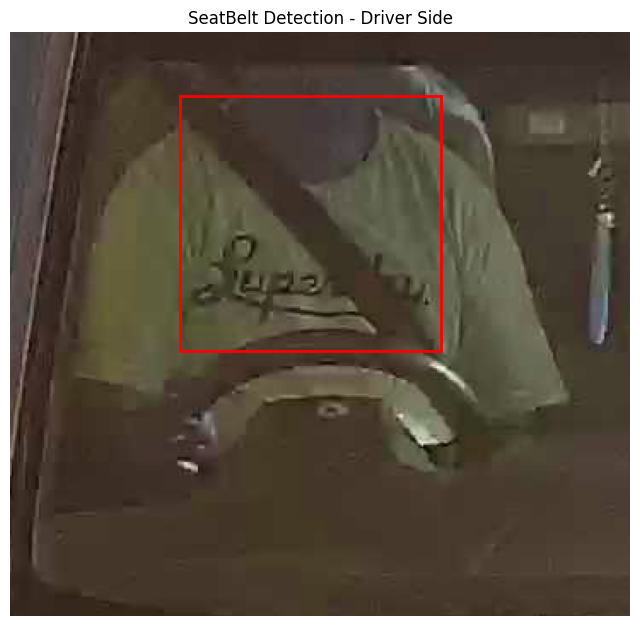



Results for Passenger Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[ 58,  48,  41],
        [ 58,  48,  41],
        [ 58,  48,  41],
        ...,
        [ 84,  76,  86],
        [ 84,  76,  86],
        [ 84,  76,  86]],

       [[ 58,  48,  41],
        [ 58,  48,  41],
        [ 59,  49,  42],
        ...,
        [ 80,  72,  82],
        [ 80,  72,  82],
        [ 80,  72,  82]],

       [[ 60,  50,  43],
        [ 60,  50,  43],
        [ 61,  51,  44],
        ...,
        [ 80,  72,  82],
        [ 80,  72,  82],
        [ 80,  72,  82]],

       ...,

       [[ 72,  59,  45],
        [ 72,  59,  45],
        [ 72,  59,  45],
        ...,
        [102,  92,  85],
        [104,  94,  87],
        [104,  94,  87]],

       [[ 72,  59,  45],
        [ 73,  60,  46],
        [ 74,  61,  47],
        ...,
        [107,  97,  90],
    

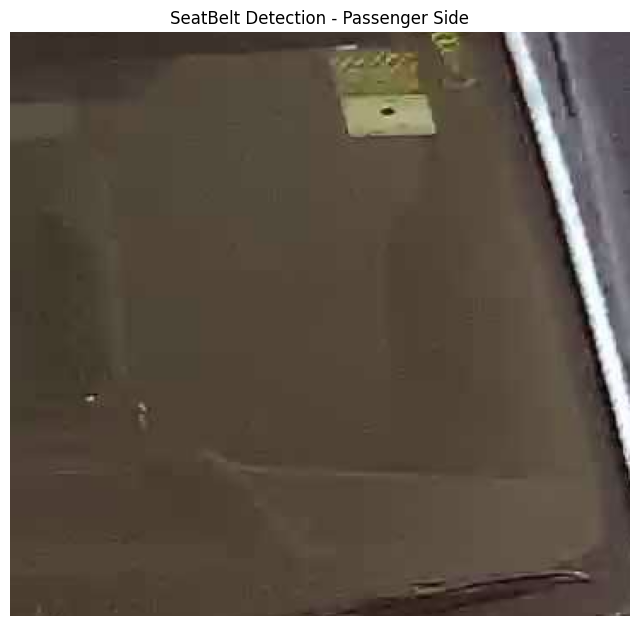

In [ ]:
# Paths to YOLO and YOLOv8 weights
yolo_weights_path = "/content/windsheildWbest.pt"
yolo_v8_weights_path = "/content/Seat_Belt_weights_dwconv.pt"


# Replace 'your_image_path.jpg' with the path to your car image
input_image_path = "/content/26_3954599.jpg"

# Run the pipeline
car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)


0: 480x800 1 car-windshield, 16.6ms
Speed: 3.4ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)
Results for windshield:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'car-windshield'}
obb: None
orig_img: array([[[44, 41, 37],
        [44, 41, 37],
        [45, 42, 38],
        ...,
        [46, 46, 46],
        [46, 46, 46],
        [46, 46, 46]],

       [[44, 41, 37],
        [44, 41, 37],
        [45, 42, 38],
        ...,
        [46, 46, 46],
        [46, 46, 46],
        [46, 46, 46]],

       [[44, 41, 37],
        [44, 41, 37],
        [45, 42, 38],
        ...,
        [46, 46, 46],
        [46, 46, 46],
        [46, 46, 46]],

       ...,

       [[32, 33, 29],
        [32, 33, 29],
        [32, 33, 29],
        ...,
        [43, 50, 53],
        [43, 50, 53],
        [43, 50, 53]],

       [[32, 33, 29],
        [32, 33, 29],
        [32,

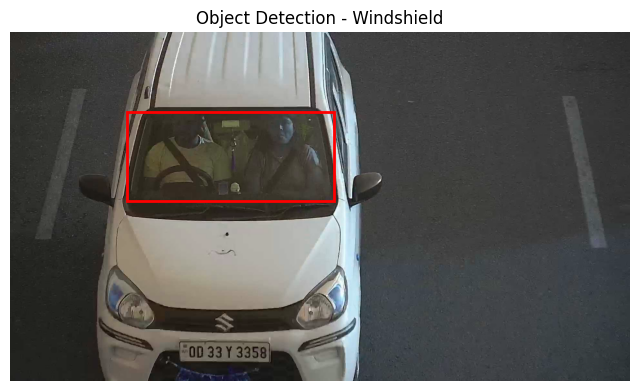




0: 576x640 1 Seat_Belt, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 Seat_Belt, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)
Results for Driver Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[103,  97,  90],
        [103,  97,  90],
        [102,  96,  89],
        ...,
        [ 51,  47,  36],
        [ 51,  47,  36],
        [ 51,  47,  36]],

       [[103,  97,  90],
        [104,  98,  91],
        [102,  96,  89],
        ...,
        [ 51,  47,  36],
        [ 49,  45,  34],
        [ 50,  46,  35]],

       [[104,  98,  91],
        [104,  98,  91],
        [103,  97,  90],
        ...,
        [ 51,  47,  36],
        [ 48,  44,  33],
        [ 50,  46,  35]],

       ...,

       [[ 67,  58,  48],
      

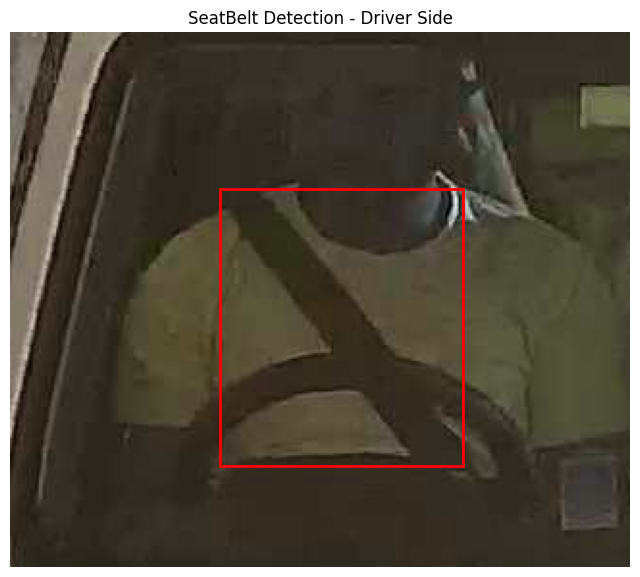



Results for Passenger Side:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Seat_Belt'}
obb: None
orig_img: array([[[ 51,  47,  36],
        [ 51,  47,  36],
        [ 51,  47,  36],
        ...,
        [ 68,  74,  79],
        [ 67,  70,  75],
        [ 86,  89,  93]],

       [[ 51,  47,  36],
        [ 52,  48,  37],
        [ 52,  48,  37],
        ...,
        [ 67,  73,  78],
        [ 68,  71,  76],
        [ 91,  94,  98]],

       [[ 51,  47,  36],
        [ 52,  48,  37],
        [ 53,  49,  38],
        ...,
        [ 66,  72,  77],
        [ 69,  72,  77],
        [ 94,  97, 101]],

       ...,

       [[ 51,  47,  36],
        [ 51,  47,  36],
        [ 51,  47,  36],
        ...,
        [ 61,  54,  51],
        [ 60,  53,  50],
        [ 59,  52,  49]],

       [[ 51,  47,  36],
        [ 51,  47,  36],
        [ 51,  47,  36],
        ...,
        [ 61,  54,  51],
    

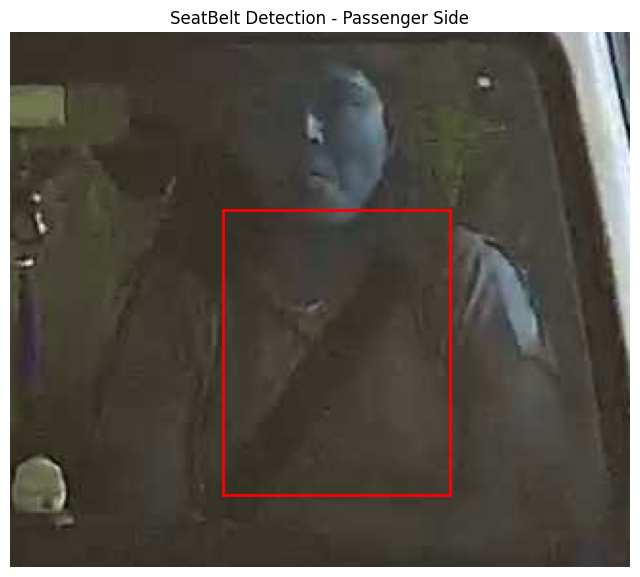

In [ ]:
# Paths to YOLO and YOLOv8 weights
yolo_weights_path = "/content/windsheildWbest.pt"
yolo_v8_weights_path = "/content/Seat_Belt_weights_dwconv.pt"


# Replace 'your_image_path.jpg' with the path to your car image
input_image_path = "/content/27_3954436.jpg"

# Run the pipeline
car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path)

In [ ]:
# # Main pipeline
# def car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path):
#     # Step 1: Perform YOLO Object Detection for Windshield
#     car_image, yolo_results = yolo_object_detection(input_image_path, yolo_weights_path)

#     # Assuming the first result is the windshield
#     windshield_box = yolo_results[0].cpu().numpy()

#     # Crop the windshield
#     x1, y1, x2, y2 = map(int, windshield_box[0:4])
#     windshield_image = car_image[y1:y2, x1:x2]

#     # Step 2: Split Windshield into Two Pictures
#     left_image, right_image = split_and_save(windshield_image, "/content/left_windsheild.jpg", "/content/right_windsheild.jpg")

#     # Step 3: Perform YOLOv8 Object Detection for Seatbelt on Left and Right Images
#     left_results = yolo_v8_object_detection("/content/left_windsheild.jpg", yolo_v8_weights_path)
#     right_results = yolo_v8_object_detection("/content/right_windsheild.jpg", yolo_v8_weights_path)

#     # Step 4: Display or Save Results
#     # Print or process the results as needed
#     print("Results for left windshield:")
#     print(left_results)

#     print("Results for right windshield:")
#     print(right_results)

In [ ]:
# # Main pipeline
# def car_pipeline(input_image_path, yolo_weights_path, yolo_v8_weights_path):
#     # Load the car image
#     car_image = cv2.imread(input_image_path)

#     # Step 1: Perform YOLO Object Detection for Windshield
#     yolo_results = yolo_object_detection(car_image, yolo_weights_path)

#     # Assuming the first result is the windshield
#     windshield_box = yolo_results[0].cpu().numpy()

#     # Crop the windshield
#     x1, y1, x2, y2 = map(int, windshield_box[0:4])
#     windshield_image = car_image[y1:y2, x1:x2]

#     # Step 2: Split Windshield into Two Pictures
#     left_image, right_image = split_image(windshield_image)

#     # Step 3: Perform YOLOv8 Object Detection for Seatbelt on Left and Right Images
#     left_results = yolo_v8_object_detection(left_image, yolo_v8_weights_path)
#     right_results = yolo_v8_object_detection(right_image, yolo_v8_weights_path)

#     # Step 4: Display or Process Results
#     # Print or process the results as needed
#     print("Results for left windshield:")
#     print(left_results)

#     print("Results for right windshield:")
#     print(right_results)